In [134]:
import numpy as np
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicClassifier
import pandas as pd
import random

In [135]:
import graphviz
from sklearn.utils import check_random_state
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold


## Defining useful functions

In [136]:
#Function to change multiclass classification to 1 vs all
def multiclass_to_binary(labels, most_common_id):
    to_binary = lambda val: 1 if val == most_common_id else 0
    to_binary_vec = np.vectorize(to_binary)

    labels_1vsall = to_binary_vec(labels)

    return labels_1vsall

In [137]:
#Function for prettifying expressions output by the symbolic classifier (denoted as SR_Classifier)
#Converts program expression -> sympy -> latex -> janky matplotlib workaround for latex formulas

from sympy import *
from IPython.display import display, Math

#Dictionary for functions in gplearn
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
    'sin': lambda x    : sin(x),
    'cos': lambda x    : cos(x),
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}

def prettify(classifier):
    expression = sympify((str(SR_classifier._program)), locals=converter)
    exp_latek = latex(expression)
    ax = plt.axes([0,0,0.3,0.3]) #left,bottom,width,height
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    
    plt.text(0.4, 0.4,'$%s$'%exp_latek, size = 50)
    plt.savefig('../figures/pretty_expression.png',dpi=300,bbox_inches='tight')

    


## Pulling Full Sample Dataset from CSV and convert to np array

In [138]:
import os
path = os.getcwd()
par = os.path.abspath(os.path.join(path, os.pardir))

data_path = os.path.join(par,'3_generate_features','dimensionless_cropped_final_feature_array.csv')
label_path = os.path.join(par,'3_generate_features','final_label_array.csv')

os.path.isfile(data_path)


True

In [139]:
pd.set_option('display.max_columns', None)

In [140]:
#Turn into DF
prototype_df = pd.read_csv(data_path)
label_df = pd.read_csv(label_path)

#Drop formula column
prototype_df = prototype_df.drop(columns='Unnamed: 0')
prototype_df.head()

,e1_avg_oxi_pos/e1_avg_oxi_neg,(e1_avg_oxi_pos+e1_avg_oxi_neg)/e1_avg_oxi_pos,(e1_avg_oxi_pos-e1_avg_oxi_neg)/e1_avg_oxi_pos,(e1_avg_oxi_pos+e1_avg_oxi_neg)/e1_avg_oxi_neg,(e1_avg_oxi_pos-e1_avg_oxi_neg)/e1_avg_oxi_neg,e1_avg_oxi_pos/e2_avg_oxi_pos,(e1_avg_oxi_pos+e2_avg_oxi_pos)/e1_avg_oxi_pos,(e1_avg_oxi_pos-e2_avg_oxi_pos)/e1_avg_oxi_pos,(e1_avg_oxi_pos+e2_avg_oxi_pos)/e2_avg_oxi_pos,(e1_avg_oxi_pos-e2_avg_oxi_pos)/e2_avg_oxi_pos,e1_avg_oxi_pos/e2_avg_oxi_neg,(e1_avg_oxi_pos+e2_avg_oxi_neg)/e1_avg_oxi_pos,(e1_avg_oxi_pos-e2_avg_oxi_neg)/e1_avg_oxi_pos,(e1_avg_oxi_pos+e2_avg_oxi_neg)/e2_avg_oxi_neg,(e1_avg_oxi_pos-e2_avg_oxi_neg)/e2_avg_oxi_neg,e1_avg_oxi_neg/e2_avg_oxi_pos,(e1_avg_oxi_neg+e2_avg_oxi_pos)/e1_avg_oxi_neg,(e1_avg_oxi_neg-e2_avg_oxi_pos)/e1_avg_oxi_neg,(e1_avg_oxi_neg+e2_avg_oxi_pos)/e2_avg_oxi_pos,(e1_avg_oxi_neg-e2_avg_oxi_pos)/e2_avg_oxi_pos,e1_avg_oxi_neg/e2_avg_oxi_neg,(e1_avg_oxi_neg+e2_avg_oxi_neg)/e1_avg_oxi_neg,(e1_avg_oxi_neg-e2_avg_oxi_neg)/e1_avg_oxi_neg,(e1_avg_oxi_neg+e2_avg_oxi_neg)/e2_avg_oxi_neg,(e1_avg_oxi_neg-e2_avg_oxi_neg)/e2_avg_oxi_neg,e2_avg_oxi_pos/e2_avg_oxi_neg,(e2_avg_oxi_pos+e2_avg_oxi_neg)/e2_avg_oxi_pos,(e2_avg_oxi_pos-e2_avg_oxi_neg)/e2_avg_oxi_pos,(e2_avg_oxi_pos+e2_avg_oxi_neg)/e2_avg_oxi_neg,(e2_avg_oxi_pos-e2_avg_oxi_neg)/e2_avg_oxi_neg,e1_MendeleevNumber/e2_MendeleevNumber,(e1_MendeleevNumber+e2_MendeleevNumber)/e1_MendeleevNumber,(e1_MendeleevNumber-e2_MendeleevNumber)/e1_MendeleevNumber,(e1_MendeleevNumber+e2_MendeleevNumber)/e2_MendeleevNumber,(e1_MendeleevNumber-e2_MendeleevNumber)/e2_MendeleevNumber,e1_Column/e1_Row,(e1_Column+e1_Row)/e1_Column,(e1_Column-e1_Row)/e1_Column,(e1_Column+e1_Row)/e1_Row,(e1_Column-e1_Row)/e1_Row,e1_Column/e2_Column,(e1_Column+e2_Column)/e1_Column,(e1_Column-e2_Column)/e1_Column,(e1_Column+e2_Column)/e2_Column,(e1_Column-e2_Column)/e2_Column,e1_Column/e2_Row,(e1_Column+e2_Row)/e1_Column,(e1_Column-e2_Row)/e1_Column,(e1_Column+e2_Row)/e2_Row,(e1_Column-e2_Row)/e2_Row,e1_Row/e2_Column,(e1_Row+e2_Column)/e1_Row,(e1_Row-e2_Column)/e1_Row,(e1_Row+e2_Column)/e2_Column,(e1_Row-e2_Column)/e2_Column,e1_Row/e2_Row,(e1_Row+e2_Row)/e1_Row,(e1_Row-e2_Row)/e1_Row,(e1_Row+e2_Row)/e2_Row,(e1_Row-e2_Row)/e2_Row,e2_Column/e2_Row,(e2_Column+e2_Row)/e2_Column,(e2_Column-e2_Row)/e2_Column,(e2_Column+e2_Row)/e2_Row,(e2_Column-e2_Row)/e2_Row,e1_AtomicWeight/e2_AtomicWeight,(e1_AtomicWeight+e2_AtomicWeight)/e1_AtomicWeight,(e1_AtomicWeight-e2_AtomicWeight)/e1_AtomicWeight,(e1_AtomicWeight+e2_AtomicWeight)/e2_AtomicWeight,(e1_AtomicWeight-e2_AtomicWeight)/e2_AtomicWeight,e1_MeltingT/e2_MeltingT,(e1_MeltingT+e2_MeltingT)/e1_MeltingT,(e1_MeltingT-e2_MeltingT)/e1_MeltingT,(e1_MeltingT+e2_MeltingT)/e2_MeltingT,(e1_MeltingT-e2_MeltingT)/e2_MeltingT,e1_CovalentRadius/e2_CovalentRadius,(e1_CovalentRadius+e2_CovalentRadius)/e1_CovalentRadius,(e1_CovalentRadius-e2_CovalentRadius)/e1_CovalentRadius,(e1_CovalentRadius+e2_CovalentRadius)/e2_CovalentRadius,(e1_CovalentRadius-e2_CovalentRadius)/e2_CovalentRadius,e1_NsValence/e1_NpValence,(e1_NsValence+e1_NpValence)/e1_NsValence,(e1_NsValence-e1_NpValence)/e1_NsValence,(e1_NsValence+e1_NpValence)/e1_NpValence,(e1_NsValence-e1_NpValence)/e1_NpValence,e1_NsValence/e1_NdValence,(e1_NsValence+e1_NdValence)/e1_NsValence,(e1_NsValence-e1_NdValence)/e1_NsValence,(e1_NsValence+e1_NdValence)/e1_NdValence,(e1_NsValence-e1_NdValence)/e1_NdValence,e1_NsValence/e1_NfValence,(e1_NsValence+e1_NfValence)/e1_NsValence,(e1_NsValence-e1_NfValence)/e1_NsValence,(e1_NsValence+e1_NfValence)/e1_NfValence,(e1_NsValence-e1_NfValence)/e1_NfValence,e1_NsValence/e1_NValence,(e1_NsValence+e1_NValence)/e1_NsValence,(e1_NsValence-e1_NValence)/e1_NsValence,(e1_NsValence+e1_NValence)/e1_NValence,(e1_NsValence-e1_NValence)/e1_NValence,e1_NsValence/e1_NsUnfilled,(e1_NsValence+e1_NsUnfilled)/e1_NsValence,(e1_NsValence-e1_NsUnfilled)/e1_NsValence,(e1_NsValence+e1_NsUnfilled)/e1_NsUnfilled,(e1_NsValence-e1_NsUnfilled)/e1_NsUnfilled,e1_NsValence/e1_NpUnfilled,(e1_NsVale

In [141]:
#Dataframe convert label into categorical variable for classification
#Then convert labels into numpy array
label_name = 'Prototype'
label_df[label_name]= pd.Categorical(label_df[label_name])
label_df['numeric_label'] = label_df[label_name].cat.codes

#Convert numerical dataframe column to array
labels = label_df['numeric_label'].to_numpy()

label_df.head()


,Prototype,numeric_label
0,Anatase#TiO2,18
1,Cristobalite#SiO2,114
2,Rutile#TiO2,298
3,Laves(2H)#MgZn2,201
4,Quartz(low)#SiO2,287


In [142]:
#Convert features to numpy
#Also define feature names for symbolic regression

# filter for features from RF feature reduction

feature_reduction_df = pd.read_csv('features_1_2pruned/13_iteration_feature_9_features.csv')

feature_reduction_feature_names = feature_reduction_df['Name'].to_numpy()

features = prototype_df[feature_reduction_feature_names].to_numpy()
feature_names = list(prototype_df[feature_reduction_feature_names].columns)

In [143]:
#Find class frequencies
label_counts = label_df['numeric_label'].value_counts()
#See pandas categorical mapping
label_dict = dict(enumerate(label_df['Prototype'].cat.categories))

label_counts[:5]




/var/folders/dj/nk2fdd2s5cl3c5mh7nkvr3040000gn/T/ipykernel_10696/3790179312.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  label_counts[:5]


203    1532
151     507
201     475
298     467
13      368
Name: numeric_label, dtype: int64

In [144]:
#Find class frequencies
#Inner expression label_df[]...index.tolist or ...values.tolist converts the value_counts index to both the index identifier as well as its value
#The index identifier is the label 
label_names_sorted = np.array(label_df['numeric_label'].value_counts().index.tolist())
label_values_sorted = np.array(label_df['numeric_label'].value_counts().values.tolist())

#Create overall labels array for ease of indexing
labels_array = np.transpose(np.stack([label_names_sorted, label_values_sorted]))

#See pandas categorical mapping to numbers
label_dict = dict(enumerate(label_df['Prototype'].cat.categories))



In [145]:
#Define most class id of interest and relabel
id_ofinterest = labels_array[0,0]

labels_1vsall = multiclass_to_binary(labels, most_common_id=id_ofinterest)

## Applying Symbolic Regression


In [146]:
#Set rng seed and permutation of data examples for training
rng = check_random_state(5)

#Check number of dominant class examples
n_positive_class = np.sum(labels_1vsall)
#Dominant class boolean index
positive_class_mask = labels_1vsall==1

#Dominant class indexing to grab for training/test set (we want 50/50 representation)
SR_features_train = features[positive_class_mask,:]
SR_target_train = labels_1vsall[positive_class_mask]

#Grabbing all negative examples of which we're going to grab a number equal to the number of dominant class
SR_negative_train = features[~positive_class_mask,:]
SR_negative_target = labels_1vsall[~positive_class_mask]

#Apply subsampling. We grab a random subset from the negative set of the same size as the positive examples
negative_scrambled_order = rng.permutation(SR_negative_target.size)
subsample_idx = negative_scrambled_order[:n_positive_class]

#Concatenate an equal amount of negative training data to the list of positive training data so we have 50/50 class representation
SR_features = np.concatenate((SR_features_train, SR_negative_train[subsample_idx,:]),axis=0)
SR_targets = np.concatenate((SR_target_train, SR_negative_target[subsample_idx]), axis=0)


In [147]:
# #Hack remove inf
# SR_features = np.delete(SR_features,221,1)

# inf_coords = np.where(np.isinf(SR_features))

# np.unique(inf_coords[1])

# #Remove from feature names
# feature_names.remove('e1_avg_oxi / e2_avg_oxi')

In [148]:
number_of_nans_per_feature = np.sum(SR_features[SR_features > 100000],axis=0)

print(number_of_nans_per_feature)

0.0


In [149]:
#Generate 20-80 splits (we're going to just use one of these for the initial pass)

#The test/train split percentage is 1/n_splits : (n_splits-1) / n_splits
#E.g. for n_splits = 5, test/train split percentage is 20:80
skf = StratifiedKFold(n_splits=5) 
splits = skf.split(SR_features,SR_targets)

In [150]:
#Use first generator output for train/test splits
#Assign these indices as variables
(SR_train_idx, SR_test_idx) = next(splits)

In [151]:
#Defining train test splits using train/test indices
SR_features_train = SR_features[SR_train_idx]
SR_target_train = SR_targets[SR_train_idx]

SR_features_test = SR_features[SR_test_idx]
SR_target_test = SR_targets[SR_test_idx]


In [152]:
#Run Classifier
SR_classifier = SymbolicClassifier(population_size = 1000, generations=40,
                         tournament_size = 30,
                         parsimony_coefficient=0.003,
                         p_crossover = 0.85,
                         p_subtree_mutation = 0.01,
                         p_point_mutation = 0.01,
                         p_hoist_mutation = 0.1,
                         feature_names=feature_names,
						 random_state=1)

SR_classifier.fit(SR_features_train, SR_target_train)

SymbolicClassifier(feature_names=['e1_Column/e2_Row',
                                  '(e1_Column+e2_Row)/e1_Column',
                                  'e2_NpValence/e2_NUnfilled',
                                  '(e2_NpValence+e2_NUnfilled)/e2_NpValence',
                                  '(e1_MeltingT+e2_MeltingT)/e1_MeltingT',
                                  '(e1_CovalentRadius+e2_CovalentRadius)/e1_CovalentRadius',
                                  '(e1_NsValence+e2_NpValence)/e1_NsValence',
                                  'e1_NsValence/e2_NpValence',
                                  '(e1_Row+e2_Column)/e1_Row'],
                   generations=40, p_crossover=0.85, p_hoist_mutation=0.1,
                   parsimony_coefficient=0.003, random_state=1,
                   tournament_size=30)

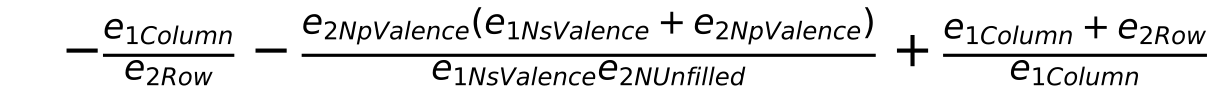

In [153]:
#Visualize expression

prettify(SR_classifier)

In [154]:
SR_classifier.score(SR_features_test, SR_target_test)


0.8711256117455138

In [155]:
#Computing the estimated probabilities on the remainder of the negative set
remainder_negative_set_idx = negative_scrambled_order[n_positive_class:]

#Getting the rest of the negative set features and values
remainder_negative_features = SR_negative_train[remainder_negative_set_idx,:]
remainder_negative_targets = SR_negative_target[remainder_negative_set_idx]

print(precision_score(remainder_negative_targets,SR_classifier.predict(remainder_negative_features)))

0.0


In [156]:
# #Hack remove inf
# remainder_negative_features = np.delete(remainder_negative_features,221,1)

# inf_coords = np.where(np.isinf(SR_features))

# np.unique(inf_coords[1])

# #Remove from feature names
# feature_names.remove('e1_avg_oxi / e2_avg_oxi')

In [157]:
#Computing estimated probabilities

estimated_classes = SR_classifier.predict_proba(remainder_negative_features)[:,1]

# estimated_classes[:20]

## Random Forest Benchmark

In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [159]:
#Naive random forest
naive_rf = RandomForestClassifier(max_depth=5, n_estimators=10)
naive_rf.fit(SR_features_train,SR_target_train)



RandomForestClassifier(max_depth=5, n_estimators=10)

In [160]:
#Stratified K fold (maintain class balance)

skf = StratifiedKFold(n_splits=5)

for i, (train_idx, test_idx) in enumerate(skf.split(SR_features,SR_targets)):
    train_features_i = SR_features[train_idx]
    train_labels_i = SR_targets[train_idx]

    test_features_i = SR_features[test_idx]
    test_labels_i = SR_targets[test_idx]

    #Fit naive rf model
    naive_rf_i = RandomForestClassifier(max_depth=5, n_estimators=10)
    naive_rf_i.fit(train_features_i, train_labels_i)

    #Fit on k-folded validation set
    test_score_i = naive_rf_i.score(test_features_i, test_labels_i)

    print(f'Fold: {i}')
    print(f'Test: {test_score_i}')





Fold: 0
Test: 0.9363784665579119
Fold: 1
Test: 0.9380097879282219
Fold: 2
Test: 0.9298531810766721
Fold: 3
Test: 0.9135399673735726
Fold: 4
Test: 0.946078431372549


In [161]:
importances = naive_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in naive_rf.estimators_], axis = 0)


/var/folders/dj/nk2fdd2s5cl3c5mh7nkvr3040000gn/T/ipykernel_10696/2528549761.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


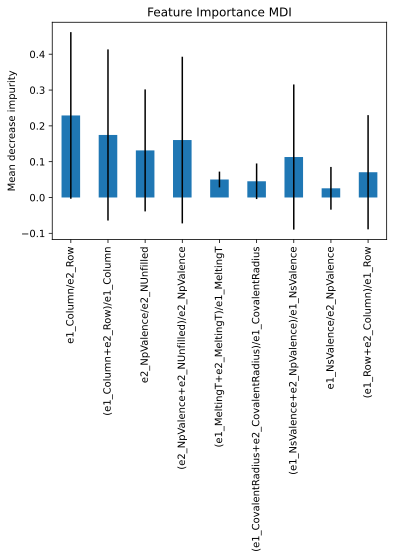

In [162]:
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

forest_importances = pd.Series(importances, index = feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = std, ax=ax)
ax.set_title('Feature Importance MDI')
ax.set_ylabel('Mean decrease impurity')
fig.tight_layout()



In [163]:
#TRIM THIS TOMORROW BASED ON FI 

## Cancer DSET (IGNORE THIS IS FOR REFERENCE)


In [164]:
rng = check_random_state(0)
cancer = load_breast_cancer()
perm = rng.permutation(cancer.target.size)
cancer.data = cancer.data[perm]
cancer.target = cancer.target[perm]

NameError: name 'load_breast_cancer' is not defined

In [ ]:
cancer.feature_names


array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [ ]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt',
                'abs', 'neg', 'inv', 'max', 'min']

In [ ]:
#Defining function set to use in symbolic classification

est = SymbolicClassifier(parsimony_coefficient=.01,
                         feature_names=cancer.feature_names,
                         random_state=1)
est.fit(cancer.data[:400], cancer.target[:400])

SymbolicClassifier(feature_names=array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23'),
                   parsimony_coefficient=0.01, random_state=1)

In [ ]:
a = sympify('mul(a,b)', locals=converter)
a

a*b

In [ ]:
est.hall_of_fame

In [ ]:
y_true = cancer.target[400:]
y_score = est.predict_proba(cancer.data[400:])[:,1]
roc_auc_score(y_true, y_score)



0.9693786982248521

In [ ]:
y_score

array([9.87333236e-01, 9.93255872e-01, 8.99437669e-02, 3.04637276e-01,
       6.02068985e-01, 9.23997536e-01, 9.87121616e-01, 9.94963460e-01,
       9.75590513e-01, 5.37858724e-01, 2.09411395e-02, 1.75012653e-02,
       3.02336598e-13, 9.57427501e-01, 5.43537457e-02, 6.09270162e-05,
       5.01672128e-01, 9.91639538e-01, 9.67743117e-01, 7.18487645e-01,
       9.50344059e-01, 5.96739523e-01, 5.71379721e-02, 9.90992282e-01,
       8.24958161e-01, 9.19846544e-01, 4.29071461e-01, 9.98715303e-01,
       5.62561330e-01, 2.27917215e-01, 7.23944395e-02, 9.97739994e-01,
       3.25215070e-03, 8.58417314e-01, 1.32715182e-06, 9.13530591e-01,
       8.88514912e-01, 6.61662375e-01, 9.97139033e-01, 5.72548424e-02,
       9.65785159e-01, 1.61758596e-05, 3.86244528e-01, 5.81764241e-04,
       9.68138024e-01, 1.00000000e+00, 1.09334878e-08, 1.20111679e-01,
       9.99953589e-01, 8.34983648e-01, 3.69815279e-01, 8.96200789e-01,
       6.02741066e-01, 7.44641139e-01, 9.99999680e-01, 6.75342556e-01,
      